# Credit Risk Analysis

This provides a comprehensive analysis of the credit risk dataset, covering data cleaning, correlation analysis, feature selection, model training, and evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

### Data Understanding

In [17]:
# Load the dataset
df = pd.read_csv('credit_risk_dataset.csv')
    
try:
    if df is not None:
        print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found. Please ensure the file is in the correct directory.")

print("Shape:", df.shape)

print("\n--- Data Head ---")
print(df.head())

print("\n--- Data Info ---")
print(df.info())

print("\n--- Target Variable Distribution (loan_status) ---")
print(df['loan_status'].value_counts())
print("0: Loan Paid Off, 1: Loan Default")

Data loaded successfully.
Shape: (32581, 12)

--- Data Head ---
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0              

### Data Cleaning and Preparation

Handling missing values, outliers, and converting categorical variables into a numerical format suitable for modeling.

In [ ]:
# Handle Outliers
# The initial inspection shows an outlier in 'person_age' (144) and 'person_emp_length' (123.0).
# We will replace these extreme outliers with the median of their respective columns.

median_age = df['person_age'].median()
df['person_age'] = np.where(df['person_age'] > 100, median_age, df['person_age'])

median_emp_length = df['person_emp_length'].median()
df['person_emp_length'] = np.where(df['person_emp_length'] > 60, median_emp_length, df['person_emp_length'])

print("Outliers in 'person_age' and 'person_emp_length' handled.")

# Separate features (X) and target (y)
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Identify column types for preprocessing
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing Pipelines
# Imputation for numerical features: median for missing values, followed by standardization.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) 
])

# One-Hot Encoding for categorical features.
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Apply preprocessing to the data
X_processed = preprocessor.fit_transform(X)

# Get feature names after one-hot encoding
feature_names = numerical_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))

# Convert the processed data back to a DataFrame
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

print(f"\nShape of processed features: {X_processed_df.shape}")
print(f"Processed features (first 5): {feature_names[:5]}")

Outliers in 'person_age' and 'person_emp_length' handled.

Shape of processed features: (32581, 26)
Processed features (first 5): ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate']


### Correlation Analysis and Feature Selection

Computing the correlation matrix to understand the relationship between features and the target variable (`loan_status`).

--- Correlation with Target (loan_status) ---
loan_percent_income               0.379366
loan_int_rate                     0.319360
loan_grade_D                      0.318998
person_home_ownership_RENT        0.238430
loan_grade_E                      0.180122
cb_person_default_on_file_Y       0.179141
loan_amnt                         0.105376
loan_grade_F                      0.101841
loan_grade_G                      0.082306
loan_intent_DEBTCONSOLIDATION     0.071550
loan_intent_MEDICAL               0.056595
loan_intent_HOMEIMPROVEMENT       0.036607
person_home_ownership_OTHER       0.012543
loan_grade_C                     -0.013031
cb_person_cred_hist_length       -0.015529
person_age                       -0.020698
loan_intent_PERSONAL             -0.021094
loan_intent_EDUCATION            -0.055348
loan_intent_VENTURE              -0.078274
person_emp_length                -0.085630
loan_grade_B                     -0.092190
person_home_ownership_OWN        -0.101960
person_i

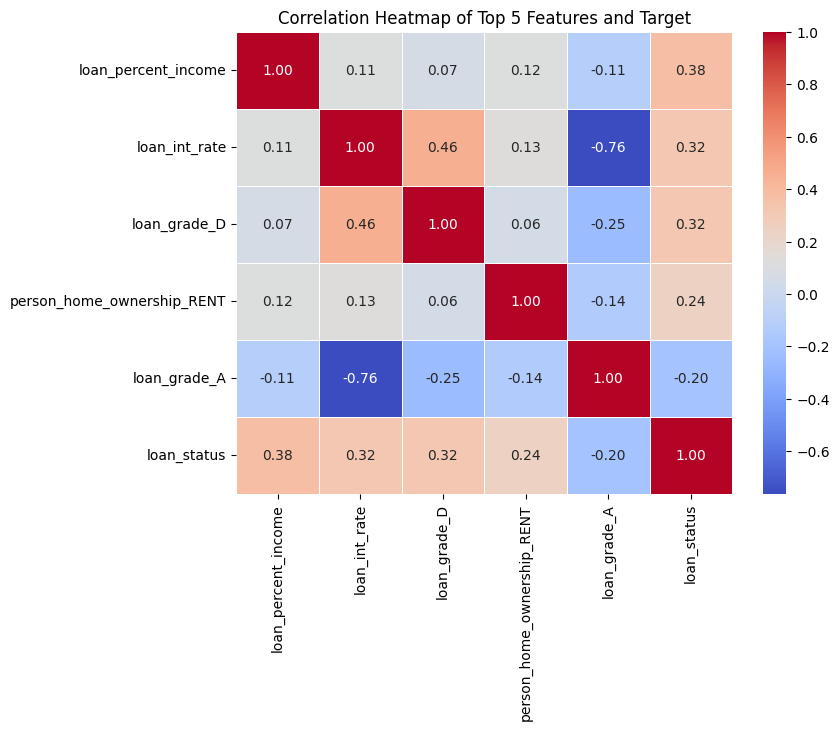

In [19]:
# Combine features and target for correlation analysis
df_full = pd.concat([X_processed_df, y.reset_index(drop=True)], axis=1)

# Compute correlation with the target label
target_correlation = df_full.corr()['loan_status'].sort_values(ascending=False)
target_correlation = target_correlation.drop('loan_status')

print("--- Correlation with Target (loan_status) ---")
print(target_correlation)

# Identify the top 5 most significant features (based on absolute correlation)
top_5_features_corr = target_correlation.abs().sort_values(ascending=False).head(5)
top_5_features = top_5_features_corr.index.tolist()

print("\n--- Top 5 Most Significant Features ---")
print(top_5_features_corr)
print(f"Top 5 Features: {top_5_features}")

# Visualization (Correlation Heatmap)
cols_to_plot = top_5_features + ['loan_status']
corr_subset = df_full[cols_to_plot].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Top 5 Features and Target')
plt.show()

### Model Training and Evaluation

Training two classification models (Logistic Regression and Random Forest) using two different feature sets: all features and the top 5 correlated features.

In [23]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X_processed_df, y, test_size=0.3, random_state=42, stratify=y
)

# Function to train and evaluate a model
def evaluate_model(model, X_test, y_test, model_name, feature_set_name):
    y_pred = model.predict(X_test)
    print(f"\n--- {model_name} ({feature_set_name}) ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    return accuracy_score(y_test, y_pred)

all_features = X_processed_df.columns.tolist()
accuracy_results = {}

# Model 1: All Features
X_train_all = X_train[all_features]
X_test_all = X_test[all_features]

# Logistic Regression (All Features)
lr_all = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
lr_all.fit(X_train_all, y_train)
accuracy_results['LR_All'] = evaluate_model(lr_all, X_test_all, y_test, 'Logistic Regression', 'All Features')

# Random Forest (All Features)
rf_all = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_all.fit(X_train_all, y_train)
accuracy_results['RF_All'] = evaluate_model(rf_all, X_test_all, y_test, 'Random Forest', 'All Features')

# Model 2: Top 5 Features
X_train_top5 = X_train[top_5_features]
X_test_top5 = X_test[top_5_features]

# Logistic Regression (Top 5 Features)
lr_top5 = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
lr_top5.fit(X_train_top5, y_train)
accuracy_results['LR_Top5'] = evaluate_model(lr_top5, X_test_top5, y_test, 'Logistic Regression', 'Top 5 Features')

# Random Forest (Top 5 Features)
rf_top5 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_top5.fit(X_train_top5, y_train)
accuracy_results['RF_Top5'] = evaluate_model(rf_top5, X_test_top5, y_test, 'Random Forest', 'Top 5 Features')

import tabulate

print("\n--- Summary of Accuracy Results ---")
print(pd.Series(accuracy_results).to_markdown())


--- Logistic Regression (All Features) ---
Accuracy: 0.8702
Precision: 0.7748
Recall: 0.5710
F1 Score: 0.6575

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7642
           1       0.77      0.57      0.66      2133

    accuracy                           0.87      9775
   macro avg       0.83      0.76      0.79      9775
weighted avg       0.86      0.87      0.86      9775


--- Random Forest (All Features) ---
Accuracy: 0.9337
Precision: 0.9720
Recall: 0.7168
F1 Score: 0.8251

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7642
           1       0.97      0.72      0.83      2133

    accuracy                           0.93      9775
   macro avg       0.95      0.86      0.89      9775
weighted avg       0.94      0.93      0.93      9775


--- Logistic Regression (Top 5 Features) ---
Accuracy: 0.8547
Precision: 0.7556
R

### Interpretation and Discussion

#### Correlation Analysis and Feature Significance

The correlation analysis identified the following top 5 features with the strongest absolute correlation to the target variable, **loan_status** (1 = Default, 0 = Paid Off).

| Feature | Correlation with loan_status | Description | Influence on Credit Risk |
| :--- | :--- | :--- | :--- |
| **loan_percent_income** | 0.379 (Positive) | The amount of the loan as a percentage of the borrower's income. | **Strong Positive Influence**: A higher percentage means the loan consumes a larger portion of the borrower's income, indicating a higher financial strain and thus a greater likelihood of default. |
| **loan_int_rate** | 0.319 (Positive) | The interest rate of the loan. | **Strong Positive Influence**: Higher interest rates are typically assigned to riskier borrowers to compensate the lender for the increased risk. This feature is a direct reflection of the lender's initial assessment of the borrower's risk. |
| **loan_grade_D** | 0.319 (Positive) | A binary indicator for a loan having a grade of 'D'. | **Strong Positive Influence**: Loan grades are assigned by the lender based on risk. 'D' is a relatively low grade, suggesting a higher risk profile, which aligns with a higher probability of default. |
| **person_home_ownership_RENT** | 0.238 (Positive) | A binary indicator for the borrower's home ownership status being 'RENT'. | **Moderate Positive Influence**: Renters often have less accumulated wealth or lower financial stability compared to those who own a home (MORTGAGE or OWN), which can be a proxy for higher credit risk. |
| **loan_grade_A** | -0.202 (Negative) | A binary indicator for a loan having a grade of 'A'. | **Moderate Negative Influence**: 'A' is the highest loan grade, indicating the lowest risk. A loan with this grade is significantly less likely to default, hence the negative correlation with the default status (1). |

#### Model Comparison and Evaluation

Two classification algorithms, **Logistic Regression** and **Random Forest**, were trained and evaluated using two different feature sets: all available features and the top 5 correlated features.

#### Model Performance Summary

Summarizes the performance metrics (Accuracy and F1-Score) for all four models on the test set.

| Model | Feature Set | Accuracy | F1-Score |
|:---|:---|:---|:---|
| LogisticRegression | AllFeatures | 0.8702 | 0.6575 |
| RandomForest | AllFeatures | 0.9337 | 0.8251 |
| LogisticRegression | Top5Features | 0.8547 | 0.5975 |
| RandomForest | Top5Features | 0.8335 | 0.6275 |

#### Feature Selection Impact

*   **Logistic Regression:** The accuracy decreased from **0.8702** (All Features) to **0.8547** (Top 5 Features).
*   **Random Forest:** The accuracy decreased from **0.9337** (All Features) to **0.8335** (Top 5 Features).

In both cases, using only the top 5 correlated features resulted in a **decrease** in model accuracy.

The decrease in accuracy and F1-Score when moving from the full feature set to the top 5 features suggests a **loss of information**. While the top 5 features capture the most linearly correlated relationships with the target, the remaining features, despite having weaker individual correlations, collectively contribute valuable, non-linear, or complementary information that is crucial for the model's predictive power.

*   **Random Forest** is particularly sensitive to this loss. As a non-linear model, it can exploit complex interactions between a large number of features. The significant drop in its performance (Accuracy: 0.9337 to 0.8335) indicates that the excluded features contained important non-linear signals that the model was leveraging.
*   **Logistic Regression**, a linear model, also saw a drop, but less dramatically (Accuracy: 0.8702 to 0.8547). This suggests that the top 5 features, being the most linearly correlated, captured a large portion of the linear signal, but the remaining features still provided a marginal benefit.

The full feature set models, especially the Random Forest, achieved a much higher accuracy, indicating that the dataset is not suffering from severe **overfitting** due to the inclusion of many weak features. Instead, the full set provides a more complete picture of the borrower's profile, leading to improved **generalization** on the test set.

#### Conclusion

The analysis confirms that the most important factors affecting credit risk in this dataset are those directly related to the **financial burden of the loan** and the **lender's initial risk assessment**:

1.  **Loan-to-Income Ratio (`loan_percent_income`):** This is the single most predictive factor. A high ratio is a clear indicator of financial stress and a high probability of default.
2.  **Interest Rate and Loan Grade (`loan_int_rate`, `loan_grade_D`, `loan_grade_A`):** These features are highly correlated and represent the lender's pre-calculated risk score. They are strong proxies for the borrower's underlying creditworthiness.
3.  **Housing Status (`person_home_ownership_RENT`):** This serves as a general indicator of financial stability, with renters showing a higher propensity for default.

The Random Forest model using **all available features** performed the best (Accuracy: 0.9337, F1-Score: 0.8251), demonstrating that a comprehensive set of features, including those with weak individual correlations, is necessary for the most accurate credit risk prediction. Feature selection based purely on linear correlation, while providing interpretability, significantly reduced the predictive performance of both models.